# Figure 3

## Imports

In [1]:
import dolfin
import matplotlib.pyplot as plt
import pandas
import numpy

import dolfin_mech as dmech

## Parameters

### Mesh

In [2]:
cube_params = {"path_and_mesh_name":"Data/generic_mesh.xdmf"}

### Material

In [3]:
alpha_lst=[0.016, 0.16, 1.6] # kPa
params = {
    "alpha":0.16,     # kPa
    "gamma":0.5,      # [-]
    "c1":0.6,         # kPa
    "c2":0.,          # kPa
    "kappa":1e2,      # kPa
    "eta":1e-5,       # kPa
    "rho_solid":1e-6} # g/mm3
mat_params = {"scaling":"linear", "parameters":params}

### Loading

In [11]:
pe = -0.5    # kPa
pi = -2.0    # kPa
g  = +9.81e3 # mm/s2

## Computing pressure-volume responses

In [38]:
results_smaller_porosity = {}
results_higher_porosity = {}
gravity_lst = [0,1]
porosity_lst=[0.5, 0.75]
for gravity_ in gravity_lst:
 for porosity_ in porosity_lst:
  for alpha_ in alpha_lst:

    mat_params["parameters"]["alpha"] = alpha_
    
    ### computing the unloaded configuration
    U_exhal_to_unloaded, phis_unloaded, dV_exhal = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=1,
        cube_params=cube_params,
        porosity_params={"type":"constant", "val":(1-porosity_)},
        mat_params=mat_params,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":0.125},
        load_params={"type":"p_boundary_condition0", "f":gravity_*g, "P0":float(pe)},
        res_basename="Fig3-inverse",
        get_results=1,
        verbose=1)
    
    V_exhal = dolfin.assemble(dolfin.Constant(1.)*dV_exhal)

    ### computing the end-inhalation configuration
    U_unloaded_to_inhal, phis_inhal, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
        cube_params=cube_params,
        move_params={"move":True, "U":U_exhal_to_unloaded},
        porosity_params={"type":"function_xml_from_array", "val":phis_unloaded},
        mat_params=mat_params,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"n_steps":2, "Deltat":1., "dt_ini":0.05, "dt_max":0.05, "dt_min":1e-4}, 
        load_params={"type":"p_boundary_condition", "f_lst":[gravity_*g, gravity_*g], "P0_lst":[float(0.), float(pi)]},
        res_basename="Fig3-direct",
        get_results=1,
        verbose=1)

    v_lst = pandas.read_csv(
        "Fig3-direct-qois.dat",
        delim_whitespace=True,
        comment="#",
        names=open("Fig3-direct-qois.dat").readline()[1:].split()).to_dict('list')["v"]
    t_lst = pandas.read_csv(
        "Fig3-direct-qois.dat",
        delim_whitespace=True,
        comment="#",
        names=open("Fig3-direct-qois.dat").readline()[1:].split()).to_dict('list')["t"]

    if porosity_==porosity[0]:
        results_smaller_porosity["pi_alpha="+str(alpha_)+"g="+str(gravity_)] = [-1*(2*t-1)*float(pi) for t in t_lst if t>=0.5]
        results_smaller_porosity["J_alpha="+str(alpha_)+"g="+str(gravity_)] = [v_lst[c]/V_exhal for c in range(len(t_lst)) if t_lst[c]>=0.5]
    else:
        results_higher_porosity["pi_alpha="+str(alpha_)+"g="+str(gravity_)] = [-1*(2*t-1)*float(pi) for t in t_lst if t>=0.5]
        results_higher_porosity["J_alpha="+str(alpha_)+"g="+str(gravity_)] = [v_lst[c]/V_exhal for c in range(len(t_lst)) if t_lst[c]>=0.5]

## Generating plots

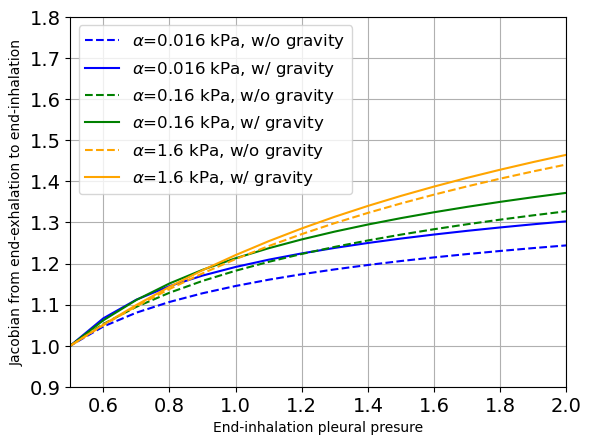

In [27]:
###### for phif=0.5
fig, ax = plt.subplots()
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=12)
plt.xlabel("End-inhalation pleural presure", fontsize=10)
plt.ylabel("Jacobian from end-exhalation to end-inhalation", fontsize=10)
color_lst = ["blue", "green", "orange"]
for alpha_ in alpha_lst:
    for gravity_ in gravity_lst:
        if gravity_:
            linestyle = "-"
            g = "w/ gravity"
        else:
            linestyle = "--"
            g = "w/o gravity"
        plt.plot(results_smaller_porosity["pi_alpha="+str(alpha_)+"g="+str(gravity_)], results_smaller_porosity["J_alpha="+str(alpha_)+"g="+str(gravity_)], color=color_lst[0], linestyle=linestyle, label=r"$\alpha$"+"="+str(alpha_)+" kPa, "+str(g))
    color_lst=color_lst[1:]
plt.xlim([0.5, 2])
plt.ylim([0.9, 1.8])
plt.legend()
plt.grid()
plt.show()

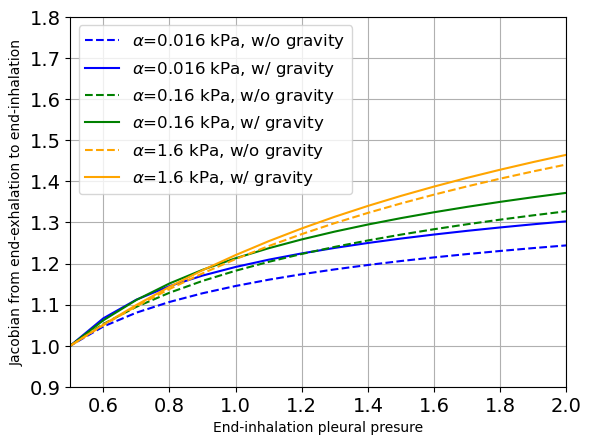

In [ ]:
###### for phif=0.75
fig, ax = plt.subplots()
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=12)
plt.xlabel("End-inhalation pleural presure", fontsize=10)
plt.ylabel("Jacobian from end-exhalation to end-inhalation", fontsize=10)
color_lst = ["blue", "green", "orange"]
for alpha_ in alpha_lst:
    for gravity_ in gravity_lst:
        if gravity_:
            linestyle = "-"
            g = "w/ gravity"
        else:
            linestyle = "--"
            g = "w/o gravity"
        plt.plot(results_higher_porosity["pi_alpha="+str(alpha_)+"g="+str(gravity_)], results_higher_porosity["J_alpha="+str(alpha_)+"g="+str(gravity_)], color=color_lst[0], linestyle=linestyle, label=r"$\alpha$"+"="+str(alpha_)+" kPa, "+str(g))
    color_lst=color_lst[1:]
plt.xlim([0.5, 2])
plt.ylim([0.9, 1.8])
plt.legend()
plt.grid()
plt.show()